In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
df = pd.read_csv("Singapore Weather Data_2004.csv")

In [3]:
df = df[1:]
df.columns = ['Time','Ambient_Temp', 'RH', 'Irradiance']

In [4]:
print(df.columns.tolist())

['Time', 'Ambient_Temp', 'RH', 'Irradiance']


In [5]:
df = df.drop(["RH", "Irradiance"], axis=1)
df = df.set_index(['Time'])

In [6]:
df

,Ambient_Temp
Time,
0,23.00000191
1,25.14400101
2,26.72449875
3,26.03775024
4,25.40000153
...,...
8756,25.50000191
8757,24.85000038
8758,24.19999886


In [ ]:
df = df.astype(float)
plt.xlabel("Time")
plt.ylabel("Temp")
plt.plot(df)

In [ ]:
#rolling stats
#Checking Stationarity
#window = 24 for 24 hours (daily mean/s.d) 
temp_rolling_mean = df.rolling(window=24).mean()
temp_rolling_std = df.rolling(window=24).std()

print(temp_rolling_mean, temp_rolling_std)

orig = plt.plot(df, color="blue", label="Original")
mean = plt.plot(temp_rolling_mean, color="red", label="Rolling Mean")
std = plt.plot(temp_rolling_std, color="black", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Std")
plt.show(block=False)
# rolling mean and s.d. not constant so not stationary

In [ ]:
#Performing Dickey-Fuller Test:
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test:")
#AIC = Akaike Information Criteria
#https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/#:~:text=The%20Akaike%20Information%20Critera%20(AIC,AIC%20is%20generally%20%E2%80%9Cbetter%E2%80%9D.
dftest = adfuller(df["Ambient_Temp"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

#Critical value is > test statistic, reject null hypothesis. So time series is stationary. Null hypothesis = time series is non-stationary
#Don't use time series when values are 1) constant 2) in the form of functions
#For time series analysis, data must be staionary
#For stationarity, you need to have 1) constant mean 2) Constant variance 3) Autocovariance that does not depend on time

In [ ]:
#Estimating Trend
df_log_scale = np.log(df)
plt.plot(df_log_scale)

In [ ]:
movingAvg = df_log_scale.rolling(window=24).mean()
movingStd = df_log_scale.rolling(window=24).std()
plt.plot(df_log_scale)
plt.plot(movingAvg, color='red')

In [ ]:
#Difference between moving avg and actual temp
#Transformations to make time series stationary

log_minus_movingAvg_df = df_log_scale - movingAvg

#Remove Nan Values
log_minus_movingAvg_df.dropna(inplace=True)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeSeries):
    #rolling stats
    #window = 24 for 24 hours (daily mean/s.d) 
    temp_rolling_mean = timeSeries.rolling(window=24).mean()
    temp_rolling_std = timeSeries.rolling(window=24).std()

    #Plot graph
    orig = plt.plot(timeSeries, color="blue", label="Original")
    mean = plt.plot(temp_rolling_mean, color="red", label="Rolling Mean")
    std = plt.plot(temp_rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Std")
    plt.show(block=False)

    #Dickey-Fuller Test
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeSeries["Ambient_Temp"], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

In [ ]:
test_stationarity(log_minus_movingAvg_df)

In [ ]:
#See trend in a time series
expWeightedAvg = df_log_scale.ewm(halflife=24, min_periods=0, adjust=True).mean()
plt.plot(df_log_scale)
plt.plot(expWeightedAvg, color="red")

In [ ]:
#Difference between log scale and weighted avg

log_minus_wAvg_df = df_log_scale - expWeightedAvg
test_stationarity(log_minus_wAvg_df)

In [ ]:
#Shift values
shift_df = df_log_scale - df_log_scale.shift()
plt.plot(shift_df)

In [ ]:
shift_df.dropna(inplace=True)
test_stationarity(shift_df)
#Time series is stationary now --> but I think even without the transformations done above, it should have been stationary already.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

#df_log_scale.sort_index(inplace= True)
decomposition = seasonal_decompose(df_log_scale, period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log_scale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedData = residual
decomposedData.dropna(inplace=True)
test_stationarity(decomposedData)

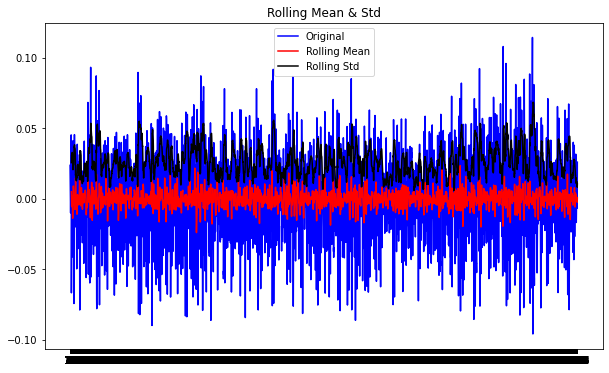

Results of Dickey-Fuller Test:


KeyError: 'Ambient_Temp'

In [20]:
#Check noise to see if it is stationary or not
decomposedData = residual
decomposedData.dropna(inplace=True)
test_stationarity(decomposedData)

c:\users\raman\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

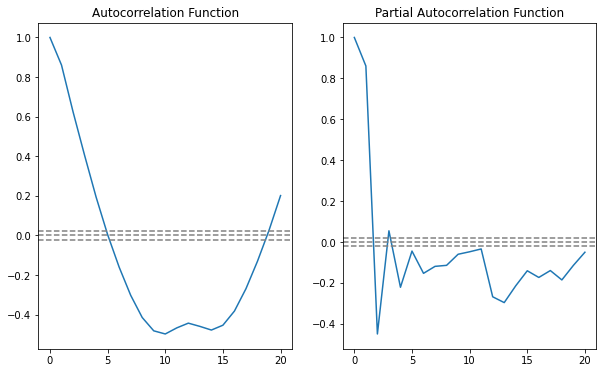

In [21]:
#ACF and PACF Gtaphs
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(shift_df, nlags=20)
lag_pacf = pacf(shift_df, nlags=20, method='ols')

#ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shift_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shift_df)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shift_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shift_df)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout

In [22]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL - order(P, d, Q)
model = ARIMA(df_log_scale, order=(5, 1, 2))
results_AR = model.fit(disp=-1)
plt.plot(shift_df)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-shift_df['Ambient_Temp'])**2))
print('Plotting AR Model')

#MA MODEL
model = ARIMA(df_log_scale, order=(3, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(shift_df)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-shift_df['Ambient_Temp'])**2))
print('Plotting MA Model')

c:\users\raman\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\raman\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An

MemoryError: Unable to allocate 581. MiB for an array with shape (8723, 8723) and data type float64

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
#Convert to cumulative sum
predictions_ARIMA_sum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_sum.head())

In [ ]:
predictions_ARIMA_log = pd.Series(df_log_scale['Ambient_Temp'].ix[0], index=df_log_scale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_sum, fill_value = 0)
predictions_ARIMA_log.head()